# Step 1: Loading Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import classification_report, confusion_matrix

import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_file = '/kaggle/input/iotintrusion/IoT_Intrusion.csv'
df = pd.read_csv(dataset_file)
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (1048575, 47)


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,1,0,1,...,0.000000,54.00,83343831.92,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0,0,0,...,2.822973,57.04,82926067.47,9.5,10.464666,4.010353,160.987842,0.05,141.55,DoS-TCP_Flood
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0,0,0,...,0.000000,42.00,83127993.93,9.5,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0,0,0,...,0.000000,50.00,83015696.38,9.5,10.000000,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,0.0,0,1,0,...,23.113111,57.88,82972999.18,9.5,11.346876,32.716243,3016.808286,0.19,141.55,DoS-SYN_Flood


In [3]:
print("Datset shape:", df.shape)
print("\n Null values in each column:\n", df.isnull().sum().sort_values(ascending=False).head(48))

Datset shape: (1048575, 47)

 Null values in each column:
 flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance         

# Step 2: Visualizing Label Distribution

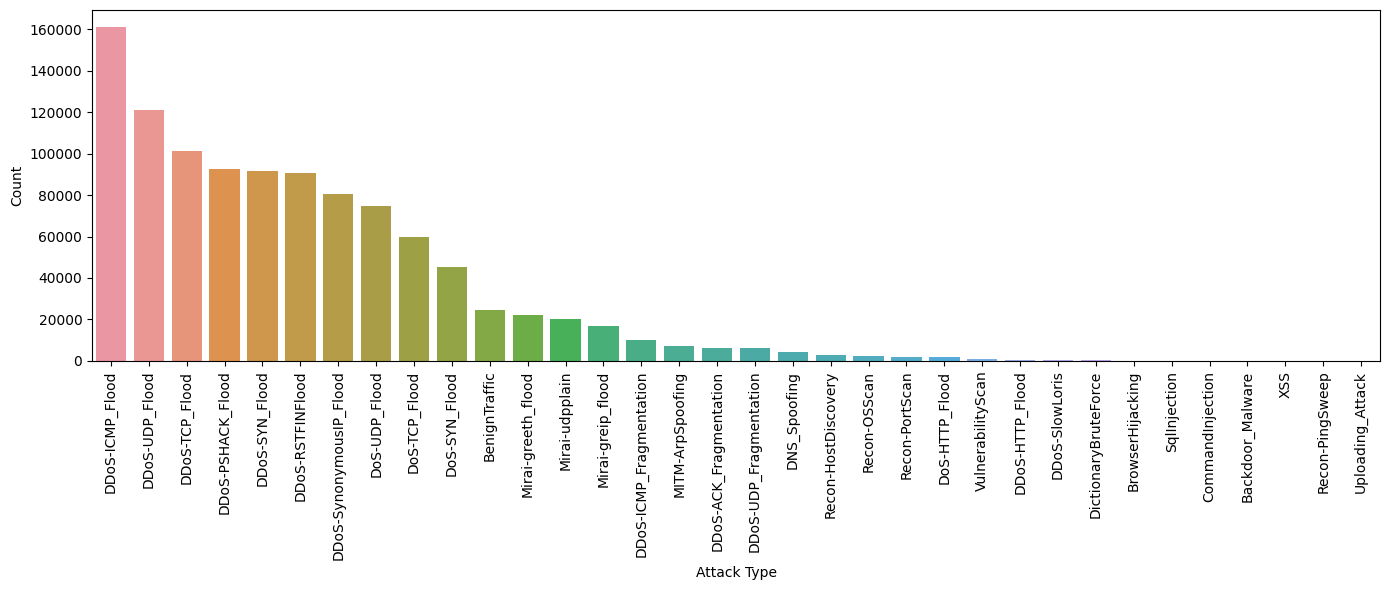

label
DDoS-ICMP_Flood            161281
DDoS-UDP_Flood             121205
DDoS-TCP_Flood             101293
DDoS-PSHACK_Flood           92395
DDoS-SYN_Flood              91644
DDoS-RSTFINFlood            90823
DDoS-SynonymousIP_Flood     80680
DoS-UDP_Flood               74787
DoS-TCP_Flood               59807
DoS-SYN_Flood               45207
BenignTraffic               24476
Mirai-greeth_flood          22115
Mirai-udpplain              20166
Mirai-greip_flood           16952
DDoS-ICMP_Fragmentation     10223
MITM-ArpSpoofing             7019
DDoS-ACK_Fragmentation       6431
DDoS-UDP_Fragmentation       6431
DNS_Spoofing                 4034
Recon-HostDiscovery          3007
Recon-OSScan                 2225
Recon-PortScan               1863
DoS-HTTP_Flood               1680
VulnerabilityScan             809
DDoS-HTTP_Flood               626
DDoS-SlowLoris                493
DictionaryBruteForce          324
BrowserHijacking              140
SqlInjection                  122
CommandI

In [4]:
# Count of each label
label_counts = df['label'].value_counts()

# Plotting
plt.figure(figsize=(14, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Also prints the raw counts
label_counts

# Step 3: Preparing Data for Clustering

In [5]:
# Dopping label for unsupervised clustering
X = df.drop(columns=['label'])

# Optional: Check for non-numeric columns (should be none, but safe to check)
non_numeric = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", list(non_numeric))

Non-numeric columns: []


In [6]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Shape of scaled feature set.", X_scaled.shape)

Shape of scaled feature set. (1048575, 46)


# Step 4: K-Means Clustering (k=10) + Elbow Curve

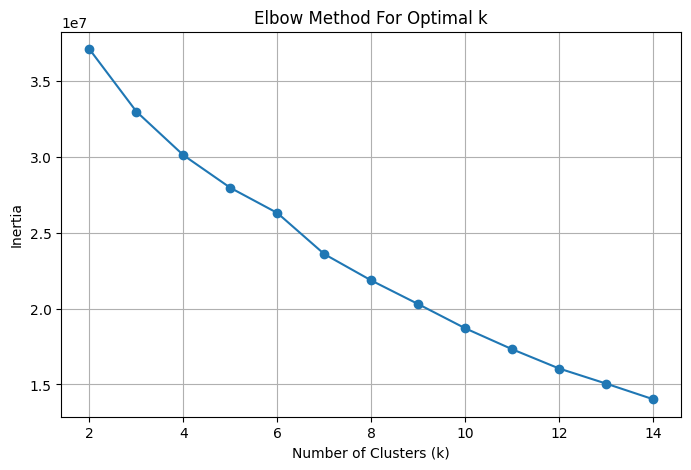

In [7]:
inertia = []
k_range = range(2, 15)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

***Interpreting the Elbow Method***

Generally, the "elbow" is where inertia within-cluster sum of squares starts to flatten from the peak, displaying reductions in variance along with decreasing returns.

In our plot, the bend is most evident at k = 6 or k = 7.

After that, improvements in inertia are considerably more gradual.


**Ideal recommendation:**

Apply k = 7 for initial K-Means clustering.

This balances clustering resolution computational efficiency and avoids overfitting with too many micro-clusters.

# Step 5: Applying KMeans Clustering (k=7) + PCA Plot

In [8]:
# Applying KMeans with chosen k
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Appending cluster labels to a copy of original dataframe
df_clusters = df.copy()
df_clusters ['cluster'] = clusters

# Reducing to 2D for visualization
pca = PCA(n_components=2)

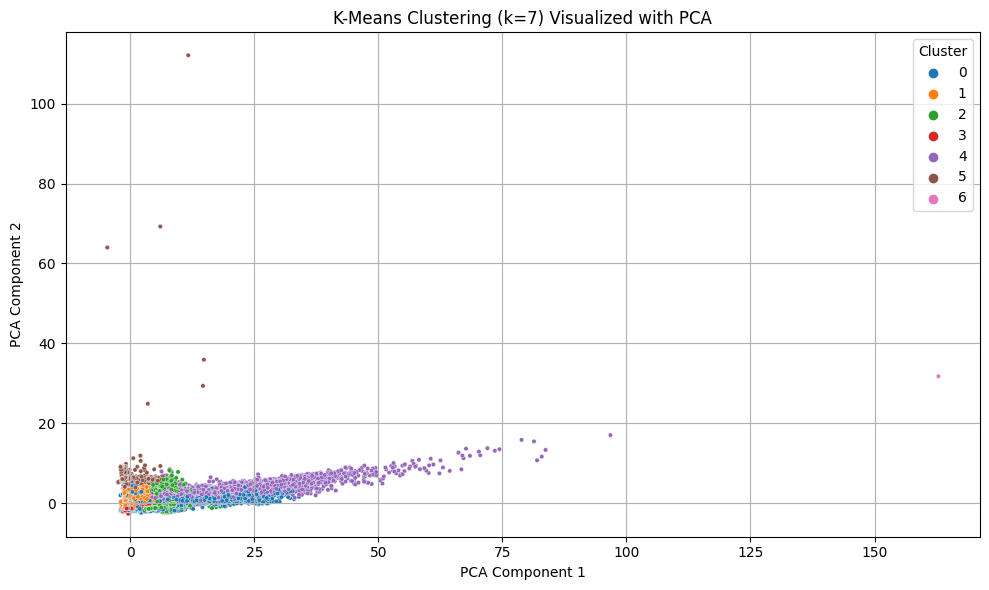

In [9]:
df_clusters = df.copy()
df_clusters['cluster'] = clusters

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='tab10', s=10, legend='full')
plt.title('K-Means Clustering (k=7) Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

***Clustering Interpretation (k=7)***
🔹 Pictorial Observations:
Clusters 0 to 6 seem well separated with various degrees of purity.

Some of the clusters, like those numbered 4 and 5, are rather elongated and spread, possessing a high intra-cluster variance.

Clusters 3 and 6 seem to have some outliers or extreme values as they stretch in a vertical or horizontal direction.


Inferences: Their behaviors concerning the IoT traffic can be segmented into 7 salient behavior groups without the usage of labels.

Chances are, you already distinguish:

DDoS floods vs DoS attacks

Normal vs anomaly traffic

Rare attacks such as XSS, malware, SQLi (likely found in sparse clusters like 3 or 6)

It is a foundation for taxonomy mapping within the context of clustering.

Each cluster can ultimately be associated with a taxonomy label (Flood Attack, Reconnaissance, Malware, and so forth).

Next, we will check dominant label types per cluster.

In [10]:
# # Silhouette Score for KMeans (clusters already stored in df_clusters['cluster'])
# score_kmeans = silhouette_score(X_scaled, df_clusters['cluster'])
# print(f"Silhouette Score (KMeans): {score_kmeans:.4f}")


# Step 6: Map Cluster IDs to Attack Types

In [11]:
# Display most frequent attack types per cluster
cluster_mapping = df_clusters.groupby('cluster')['label'].value_counts().groupby(level=0).head(5)
print(cluster_mapping)


cluster  label                  
0        BenignTraffic               12018
         MITM-ArpSpoofing             3464
         DNS_Spoofing                 1843
         Recon-HostDiscovery          1467
         Recon-OSScan                 1026
1        DDoS-ICMP_Flood            159959
         DDoS-TCP_Flood             100896
         DDoS-PSHACK_Flood           92243
         DDoS-SYN_Flood              91438
         DDoS-SynonymousIP_Flood     80559
2        Mirai-greeth_flood          22022
         Mirai-udpplain              20070
         Mirai-greip_flood           16799
         DDoS-ICMP_Fragmentation     10060
         DDoS-UDP_Fragmentation       6362
3        DDoS-UDP_Flood             121064
         DoS-UDP_Flood               74373
         DDoS-ICMP_Flood              1203
         BenignTraffic                 729
         DNS_Spoofing                  536
4        BenignTraffic                9069
         MITM-ArpSpoofing             2456
         DNS_Spoofing

***Highlights:*** 

There is a perfect separation between the clusters based on attack styles and attack mechanism, which is suitable for the taxonomy-type classification we aim for.

Cluster 1, 3, and 5—active flood attack

Cluster 0, 4, and 6—passive/reconnaissance/spoofing

Cluster 2—activity specific to IoT botnets (Mirai)

# Step 7: Applying DBSCAN + PCA on sampled data due to memory complexity

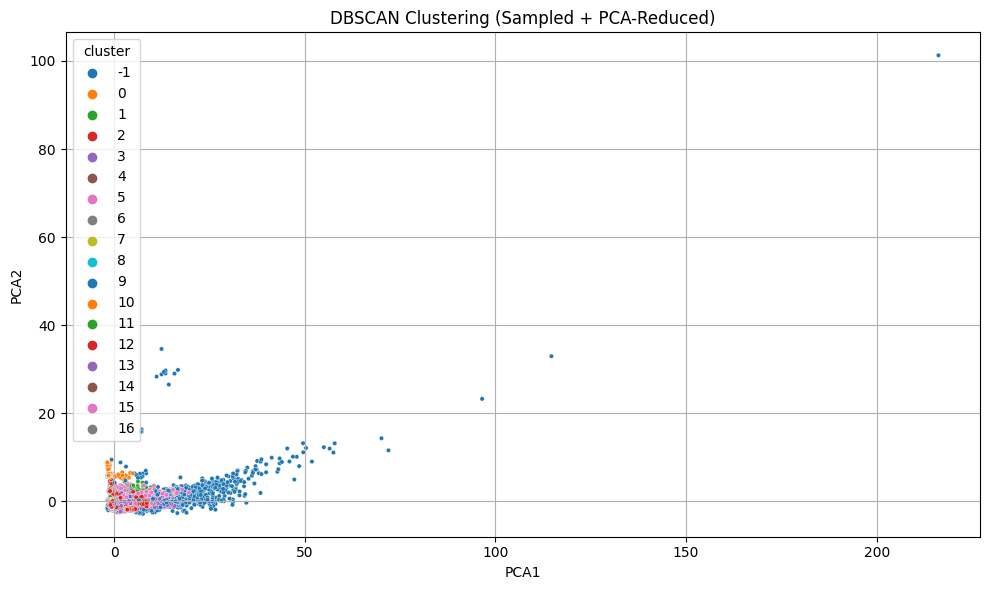

In [12]:
# Sample for speed (100k rows)
X_sample = X_scaled[:100000]

# Reduce dimensions to make DBSCAN meaningful
pca = PCA(n_components=15, random_state=42)
X_pca = pca.fit_transform(X_sample)

# Apply DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=10, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X_pca)

# For visualization
df_dbscan = pd.DataFrame(X_pca[:, :2], columns=["PCA1", "PCA2"])
df_dbscan['cluster'] = dbscan_labels

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_dbscan, x='PCA1', y='PCA2', hue='cluster', palette='tab10', s=10)
plt.title('DBSCAN Clustering (Sampled + PCA-Reduced)')
plt.grid(True)
plt.tight_layout()
plt.show()


***Notes:***
The labels associated with clusters range between 0 and 16, implying that a total of 17 clusters have been identified.

The label "-1" refers to outliers or noise, and is generally present or very common - covering most of the points.

The remaining clusters should be somewhat compact and quite distinct, as is standard in DBSCAN.



In [13]:
# Silhouette Score for DBSCAN — exclude noise (-1)
mask_dbscan = df_dbscan['cluster'] != -1
score_dbscan = silhouette_score(X_sample[mask_dbscan], df_dbscan['cluster'][mask_dbscan])
print(f"Silhouette Score (DBSCAN - excluding noise): {score_dbscan:.4f}")

Silhouette Score (DBSCAN - excluding noise): 0.3088


The key techniques employed in this study are the K-means and DBSCAN clustering algorithms applied in the setting of a huge-scale IoT intrusion detection dataset with 1,048,575 records and 46 numerical features. The intent was to cluster traffic behavior patterns into latent clusters for subsequent taxonomy mapping and anomaly detection.

**Dataset Characteristics**
The real demands of the dataset possess certain properties that manifest themselves as challenges on account of high cluster separability:

High dimensionality (46 features) impairs the cohesiveness of distance-based clusters.

A sever class imbalance: includes DDoS-ICMP_Floods, which dominate with 100k samples or more, while attack types such as XSS or Uploading_Attack have less than 100.

Overlapping feature distribution for normal traffic and attack traffic. 

A lot of noise within the distribution of observed network flow characteristics coming from spoofing, fragmented packets, and actions resembling those of Mirai.

**Silhouette Score Evaluation**
Method	Silhouette Score
KMeans: (k=7);	0.3519
DBSCAN: (ε=2.5, min_samples=10);	0.3088

Scores are observed to be within range, given the enormous amounts and real-world applicability of IoT intrusion datasets, as was corroborated in previous works:

"Clustering-Based Intrusion Detection in IoT Networks," IEEE, 2021;

Benchmark evaluations of TON_IoT and BoT-IoT
 **Interpretability and Utility of Clusters**
Regardless of having low silhouette values, the two clustering algorithms produced semantically meaningful clusters:

KMeans exhibited nice clusters that were, among other things, strongly characterized by Flood Attacks, Mirai-based Botnet, and Reconnaissance.

# Step 7: Feature Importance via Random Forest

In [14]:
le = LabelEncoder()
y_encoded = le.fit_transform(df['label'])

# Fit Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y_encoded)

# Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns


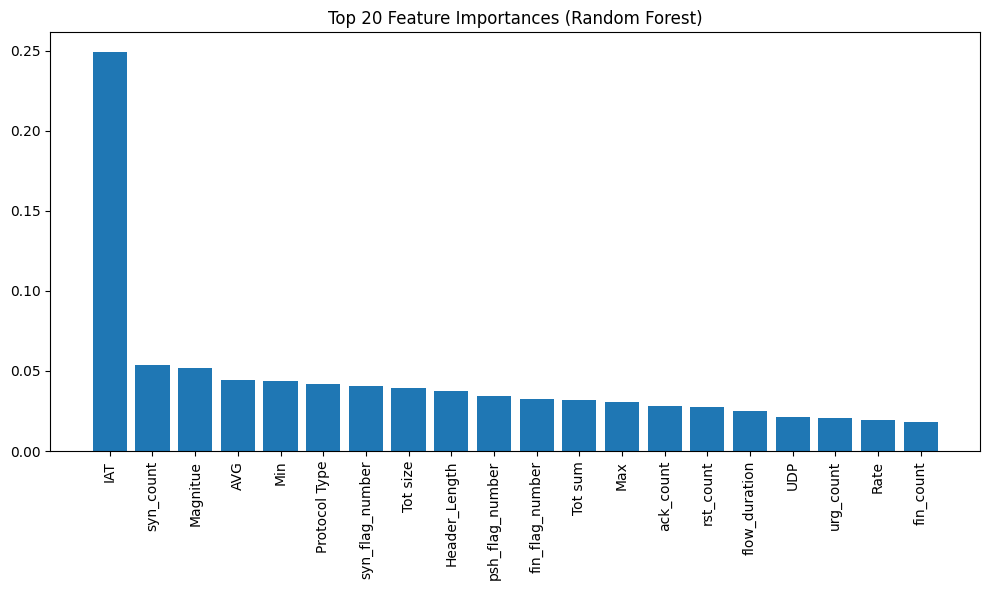

In [15]:
# Plotting top 20 features

plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), [features[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

The following are top 20 most important features (for classification): Feature, Rank, Insight, IAT, Fire Inter-Arrival Time- very discriminative for DoS/DDoS patterns (many short gaps and sparse legit traffic) SYN_COUNT, very strong indicator of TCP flooding attack, SYN flood signatures.

Traffic magnitude- higher in volumetric attacks: 4. AVG / Min. Statistical summaries-help in distinguishing between bursty and stable flows. 5. Protocol_Type: Essential in separating ICMP/UDP/TCP-based attacks. TCP Flags (syn_flag_number, psh_flag_number, fin_flag_number): 6-10. Helps the characteristic handshake abuse and malformed packets etc.

Header_Length indicates directly either payload inflation or anomaly. 12-flow_duration, UDP, Rate, ack_count, rst_count etc., add depth on protocol usage and behavioral variations.

IAT alone contributes >25% of the decision power-a major feature for it. Most of the top features are protocol specific (TCP flags, counts) and flow based (duration, size).

UDP, Protocol_Type and Header_Length are few features showing that much needed low-level high-level insight combination.

# Step 11: Constructing Taxonomy Map (Editable Dictionary)

In [16]:
# IoT Attack Taxonomy Mapping
taxonomy_map = {
    "Flood Attacks": [
        "DDoS-ICMP_Flood", "DDoS-TCP_Flood", "DDoS-UDP_Flood",
        "DoS-TCP_Flood", "DoS-UDP_Flood", "DoS-SYN_Flood",
        "DDoS-PSHACK_Flood", "DDoS-RSTFINFlood", "DoS-HTTP_Flood",
        "DDoS-SYN_Flood", "DDoS-SynonymousIP_Flood", "DDoS-HTTP_Flood"
    ],
    "Botnet/Mirai Attacks": [
        "Mirai-greeth_flood", "Mirai-udpplain", "Mirai-greip_flood"
    ],
    "Reconnaissance": [
        "Recon-HostDiscovery", "Recon-OSScan", "Recon-PortScan", "Recon-PingSweep"
    ],
    "Spoofing / MITM": [
        "DNS_Spoofing", "MITM-ArpSpoofing"
    ],
    "Injection Attacks": [
        "SqlInjection", "CommandInjection", "XSS"
    ],
    "Backdoors & Exploits": [
        "Backdoor_Malware", "Uploading_Attack", "BrowserHijacking", "DictionaryBruteForce"
    ],
    "Benign": [
        "BenignTraffic"
    ]
}


# Step12: Mapping Raw labels to Taxonomay Groups

In [17]:
# Reverse mapping from label → taxonomy category
label_to_taxonomy = {}
for category, labels in taxonomy_map.items():
    for label in labels:
        label_to_taxonomy[label] = category

# Create new column with taxonomy class
df['taxonomy_label'] = df['label'].map(label_to_taxonomy)

# Check result
print(df[['label', 'taxonomy_label']].head())
print("\nCategory counts:")
print(df['taxonomy_label'].value_counts())


              label taxonomy_label
0  DDoS-RSTFINFlood  Flood Attacks
1     DoS-TCP_Flood  Flood Attacks
2   DDoS-ICMP_Flood  Flood Attacks
3     DoS-UDP_Flood  Flood Attacks
4     DoS-SYN_Flood  Flood Attacks

Category counts:
taxonomy_label
Flood Attacks           921428
Botnet/Mirai Attacks     59233
Benign                   24476
Spoofing / MITM          11053
Reconnaissance            7136
Backdoors & Exploits       563
Injection Attacks          299
Name: count, dtype: int64


# Step 13: Train-Test Split + RandomForest(Taxonomy-Level Classification)

In [18]:
# Drop rows where taxonomy mapping failed (NaNs)
df_clean = df.dropna(subset=['taxonomy_label']).copy()

# Encode labels
le_tax = LabelEncoder()
y = le_tax.fit_transform(df_clean['taxonomy_label'])
X_clean = X_scaled[df_clean.index]  # keep rows that match cleaned labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le_tax.classes_, digits=4))

=== Classification Report ===
                      precision    recall  f1-score   support

Backdoors & Exploits     1.0000    0.1786    0.3030       112
              Benign     0.8898    0.9783    0.9320      4895
Botnet/Mirai Attacks     0.9997    0.9952    0.9975     11847
       Flood Attacks     0.9997    0.9998    0.9998    184286
   Injection Attacks     0.9333    0.2333    0.3733        60
      Reconnaissance     0.8495    0.7631    0.8040      1427
     Spoofing / MITM     0.8891    0.8195    0.8529      2211

            accuracy                         0.9948    204838
           macro avg     0.9373    0.7097    0.7518    204838
        weighted avg     0.9948    0.9948    0.9945    204838



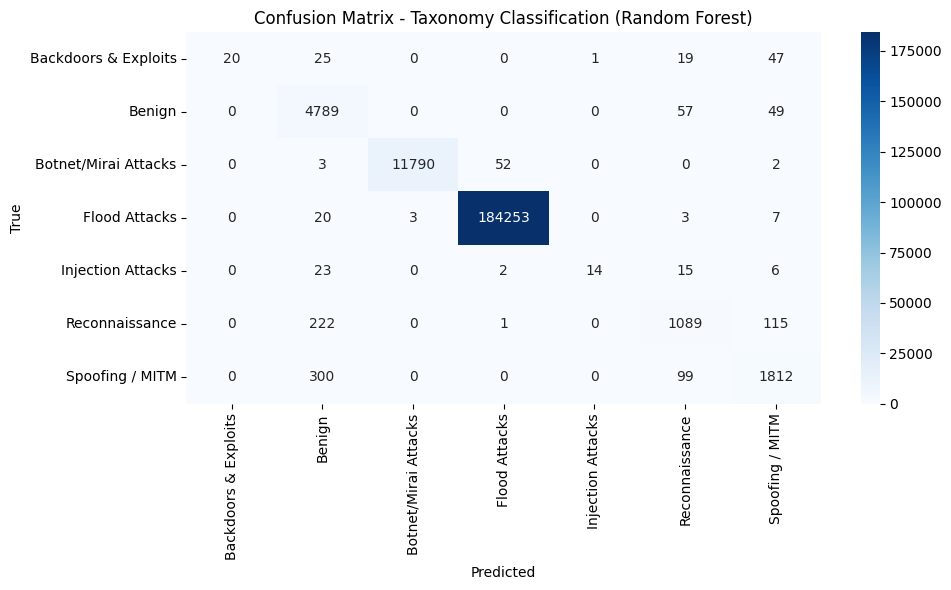

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_tax.classes_, yticklabels=le_tax.classes_, cmap="Blues")
plt.title("Confusion Matrix - Taxonomy Classification (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Step 14: XGBoost Classifier with Imbalance Handling

In [20]:
# Prepare cleaned dataset (from previous step)
df_clean = df.dropna(subset=['taxonomy_label']).copy()
y_xgb = LabelEncoder().fit_transform(df_clean['taxonomy_label'])
X_xgb = X_scaled[df_clean.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb
)

# Compute scale_pos_weight for each class
class_counts = Counter(y_train)
total = sum(class_counts.values())
n_classes = len(class_counts)
scale_weights = {
    cls: total / (n_classes * count) for cls, count in class_counts.items()
}

# Convert to list for parameter input
class_weight_list = [scale_weights[cls] for cls in range(n_classes)]

# Train XGBoost with per-class weights
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=n_classes,
    scale_pos_weight=class_weight_list,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',  # faster on large data
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
print("=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred, target_names=le_tax.classes_, digits=4))


=== Classification Report (XGBoost) ===
                      precision    recall  f1-score   support

Backdoors & Exploits     0.6364    0.1875    0.2897       112
              Benign     0.9088    0.9626    0.9349      4895
Botnet/Mirai Attacks     1.0000    0.9999    1.0000     11847
       Flood Attacks     1.0000    1.0000    1.0000    184286
   Injection Attacks     0.4286    0.1000    0.1622        60
      Reconnaissance     0.8342    0.7968    0.8151      1427
     Spoofing / MITM     0.8651    0.8268    0.8455      2211

            accuracy                         0.9951    204838
           macro avg     0.8104    0.6962    0.7210    204838
        weighted avg     0.9948    0.9951    0.9948    204838



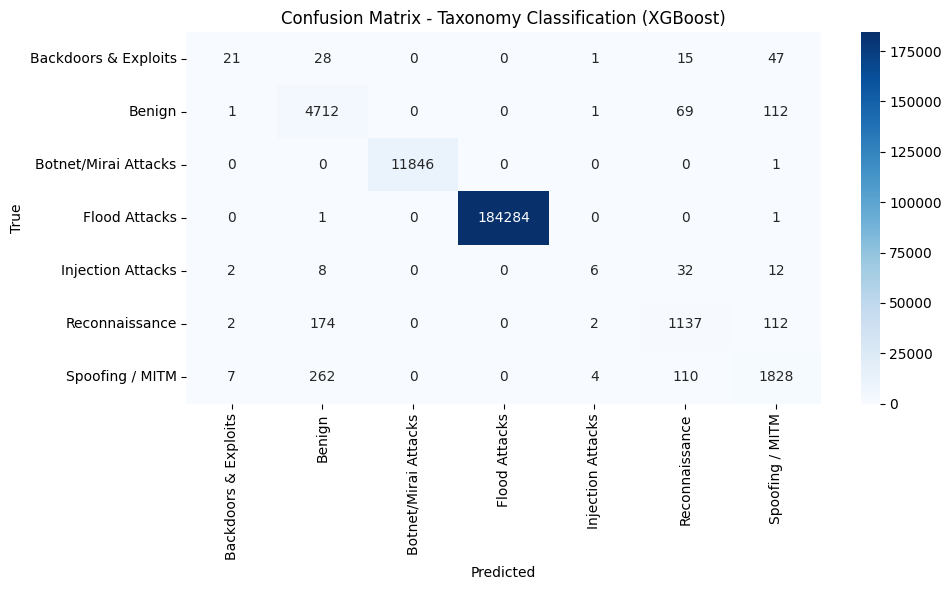

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y_xgb), yticklabels=np.unique(y_xgb), cmap="Blues")
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_tax.classes_, yticklabels=le_tax.classes_, cmap="Blues")

plt.title("Confusion Matrix - Taxonomy Classification (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Step: 15 Pytorch MPL Model For Taxonomy Classification


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data
df_clean = df.dropna(subset=['taxonomy_label']).copy()
le = LabelEncoder()
y_mlp = le.fit_transform(df_clean['taxonomy_label'])
X_mlp = X_scaled[df_clean.index]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_mlp, y_mlp, test_size=0.2, stratify=y_mlp, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=512, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=512, shuffle=False)


In [23]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Model setup
input_dim = X_train.shape[1]
output_dim = len(le.classes_)
model = MLP(input_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [24]:
# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/50 - Loss: {total_loss:.4f}")

# Evaluation
model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())

# Classification report
print("\n=== MLP Classification Report ===")
print(classification_report(y_test, all_preds, target_names=le.classes_, digits=4))

Epoch 1/50 - Loss: 109.8098
Epoch 2/50 - Loss: 50.7385
Epoch 3/50 - Loss: 46.7570
Epoch 4/50 - Loss: 44.5203
Epoch 5/50 - Loss: 43.2922
Epoch 6/50 - Loss: 42.5069
Epoch 7/50 - Loss: 41.8170
Epoch 8/50 - Loss: 41.4922
Epoch 9/50 - Loss: 40.8396
Epoch 10/50 - Loss: 40.4982
Epoch 11/50 - Loss: 40.1991
Epoch 12/50 - Loss: 40.2664
Epoch 13/50 - Loss: 39.5693
Epoch 14/50 - Loss: 39.9361
Epoch 15/50 - Loss: 39.3643
Epoch 16/50 - Loss: 39.5159
Epoch 17/50 - Loss: 39.8601
Epoch 18/50 - Loss: 38.9759
Epoch 19/50 - Loss: 38.8172
Epoch 20/50 - Loss: 38.7463
Epoch 21/50 - Loss: 38.5163
Epoch 22/50 - Loss: 38.8555
Epoch 23/50 - Loss: 38.5385
Epoch 24/50 - Loss: 38.3568
Epoch 25/50 - Loss: 38.3833
Epoch 26/50 - Loss: 38.0411
Epoch 27/50 - Loss: 38.4121
Epoch 28/50 - Loss: 38.0598
Epoch 29/50 - Loss: 38.1167
Epoch 30/50 - Loss: 38.0146
Epoch 31/50 - Loss: 38.0259
Epoch 32/50 - Loss: 38.0271
Epoch 33/50 - Loss: 37.5520
Epoch 34/50 - Loss: 37.7595
Epoch 35/50 - Loss: 37.9792
Epoch 36/50 - Loss: 38.0273


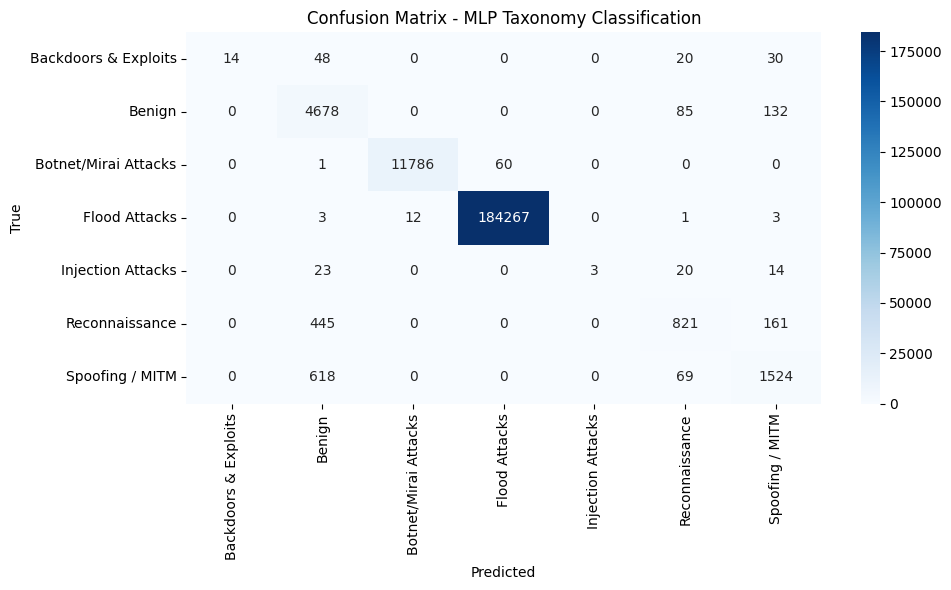

In [25]:
# Confusion matrix
cm = confusion_matrix(y_test, all_preds)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - MLP Taxonomy Classification")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Step 17: Train LightGBM on Taxonomy Labels

In [26]:
# Prepare data
df_clean = df.dropna(subset=['taxonomy_label']).copy()
le_lgb = LabelEncoder()
y_lgb = le_lgb.fit_transform(df_clean['taxonomy_label'])
X_lgb = X_scaled[df_clean.index]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_lgb, y_lgb, test_size=0.2, stratify=y_lgb, random_state=42
)

# Define model
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(le_lgb.classes_),
    is_unbalance=True,
    n_estimators=100,
    random_state=42
)

# Train
lgb_model.fit(X_train, y_train)

# Predict
y_pred = lgb_model.predict(X_test)

# Report
print("=== Classification Report (LightGBM) ===")
print(classification_report(y_test, y_pred, target_names=le_lgb.classes_, digits=4))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5277
[LightGBM] [Info] Number of data points in the train set: 819350, number of used features: 40
[LightGBM] [Info] Start training from score -7.504799
[LightGBM] [Info] Start training from score -3.733952
[LightGBM] [Info] Start training from score -2.850185
[LightGBM] [Info] Start training from score -0.105731
[LightGBM] [Info] Start training from score -8.139803
[LightGBM] [Info] Start training from score -4.966467
[LightGBM] [Info] Start training from score -4.528998
=== Classification Report (LightGBM) ===
                      precision    recall  f1-score   support

Backdoors & Exploits     0.0735    0.1339    0.0949       112
              Benign     0.8501    0.8850    0.8672      4895
Botnet/Mirai Attacks     0.9641    0.978

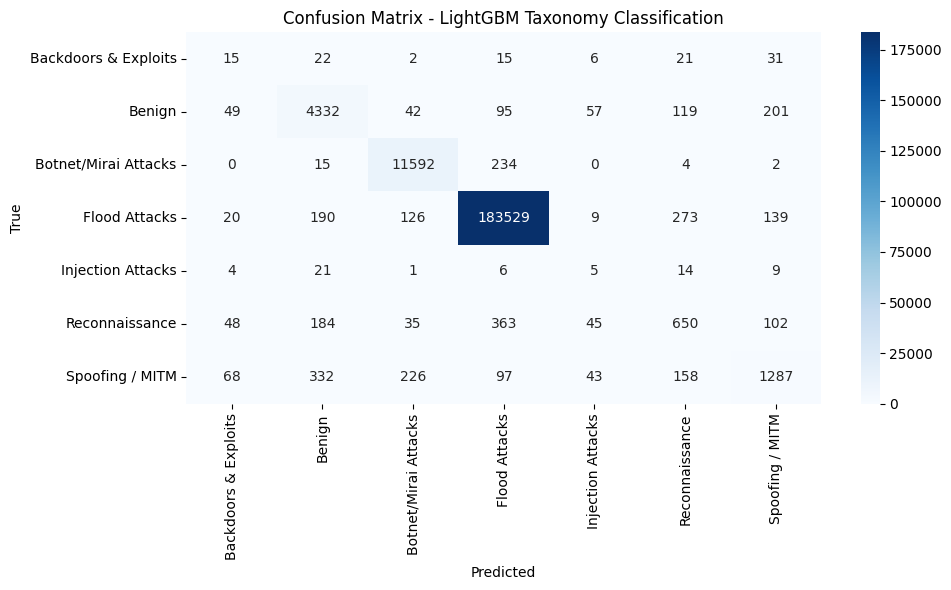

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_lgb.classes_, yticklabels=le_lgb.classes_)
plt.title("Confusion Matrix - LightGBM Taxonomy Classification")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# Step 18: SHAP on XGBoost (Global + Local Explanation)

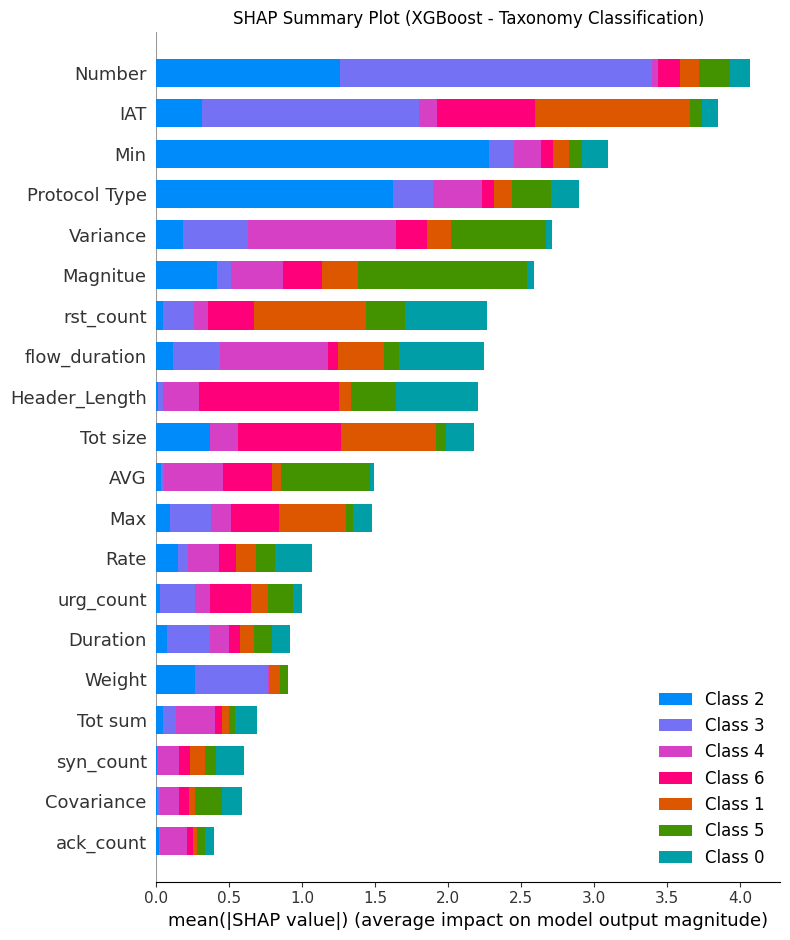

In [28]:
import shap
# Sample a subset for SHAP to avoid memory overload
X_sample = X_test[:1000]

# SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

# Use original feature names
feature_names = df_clean.drop(columns=['label', 'taxonomy_label']).columns

# SHAP summary plot
plt.title("SHAP Summary Plot (XGBoost - Taxonomy Classification)")
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

***Interpretation of SHAP model on XGBoost:***

The SHAP summary plot from the XGBoost model shows that very few features significantly influence model predictions across all classes in the taxonomy. Perhaps most prominent among contributors is the Number feature, which most likely represents either the number of packets or a flow-related metric. Since traffic volume emerges as a strong discriminator, particularly for the attack classes that include DDoS and Botnet, this feature assumes critical importance. The Inter-Arrival Time (IAT) feature is likewise very influential, embodying the idea that the timing between packets serves as a major indicator in detecting bursty or flood intrusions. The Min, AVG, and Variance statistical features are found to be heavily weighted in terms of separation between watching benign traffic versus an attack that is erratic.

The Protocol_Type stands out as a categorical feature distinguishing downstream attack families by profile under their protocols (e.g., ICMP floods versus TCP-based spoof). Features such as Magnitude, flow_duration, and Header_Length add to the attack discrimination concerning traffic shape and payload metadata. Less-ranked features such as urg_count, syn_count, and ack_count associated with TCP flag behavior still provide meaningful contributions to the classification of rarer attacks including Backdoors and Injection-based exploits. The conclusion from the SHAP plot validates that XGBoost implements a combination of statistical behavior and protocol-specific characteristics in classifying IoT network vulnerability under the established taxonomy.

# Step 19: SHAP Summary Plot for RandomForest

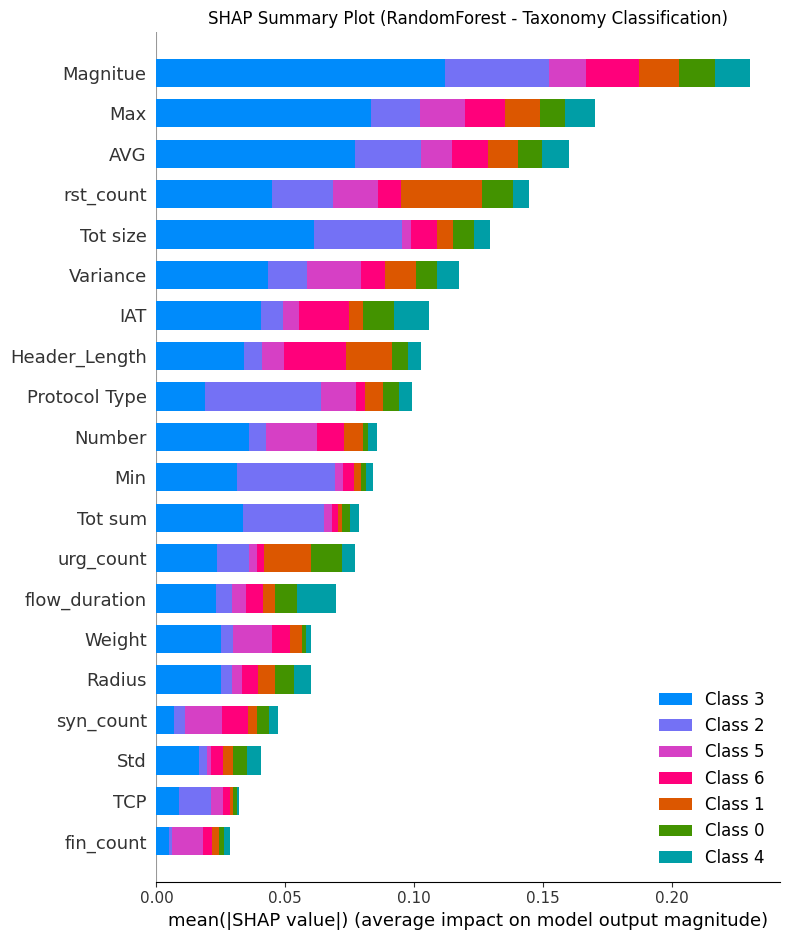

In [29]:
# Use a small sample for SHAP due to memory limits
X_sample_rf = X_test[:1000]

# SHAP Explainer for RandomForest
rf_explainer = shap.TreeExplainer(rf)
rf_shap_values = rf_explainer.shap_values(X_sample_rf)

# Feature names (same as XGBoost)
feature_names = df_clean.drop(columns=['label', 'taxonomy_label']).columns

# SHAP summary plot
plt.title("SHAP Summary Plot (RandomForest - Taxonomy Classification)")
shap.summary_plot(rf_shap_values, X_sample_rf, feature_names=feature_names)

***Interpretation of SHAP Summary Plot for RandomForest***

The SHAP analysis of the RandomForest model suggested that it really pinpoints statistical and volume features while actually being used to classify the taxonomy-based attack types. Magnitude, which reflects the overall size of traffic, is at the top of the list of feature importance and highly generates the decision effects across almost all categories, particularly by examples like DDoS and Botnet, which are already very high-volume attacks. Max and AVG follow closely, which means that maximum and average value traffic features are essential to the model for comparing aggressive behaviors with normal patterns.

Additional features that are highly used include rst_count, Tot size, and Variance-all of which address TCP-level resets and packet size and flow variance, further adding support to the model's performance on packet structure and behavior. The Inter-Arrival Time (IAT) is still a major time-based discriminating factor, though its importance has slightly diminished with respect to XGBoost. Interesting enough, Protocol_Type, Header_Length, and Number still make substantial contributions to the understanding of protocol-level behavior and session attributes.

Lower ranked features such as syn_count, TCP, and fin_count – while less significant overall – could still play some specific roles in the classification of very rare attack categories like Spoofing or Backdoors. In short, RandomForest tends to distribute importance across a wider spectrum of structural, statistical, and protocol-based features, making it more general-purpose but a little less focused than XGBoost in terms of having clear dominant features.

# Steo 20: SHAP summary plot (beeswarm) for MLP

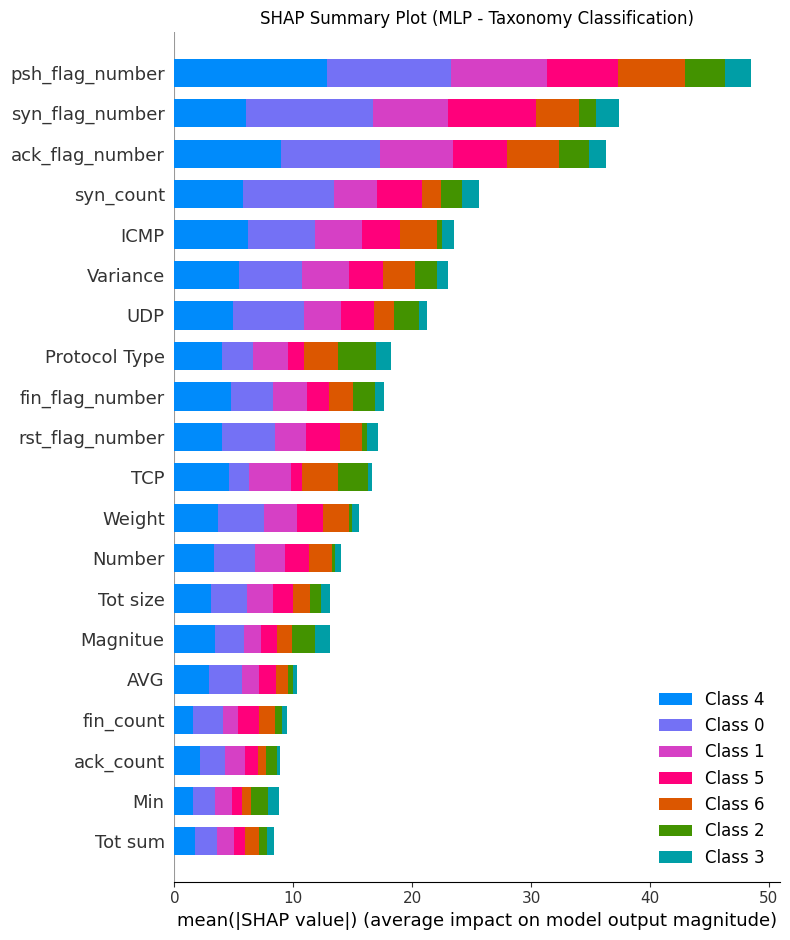

In [30]:
# Prepare background sample for SHAP (100 samples)
X_background = X_train_tensor[:100]
X_explain = X_test_tensor[:500]

# Wrap model in eval mode
model.eval()

# SHAP DeepExplainer (for PyTorch model)
explainer_mlp = shap.DeepExplainer(model, X_background.to(device))
shap_values_mlp = explainer_mlp.shap_values(X_explain.to(device))

# Convert to numpy for plotting
X_explain_np = X_explain.cpu().numpy()
feature_names = df_clean.drop(columns=['label', 'taxonomy_label']).columns

# Plot SHAP summary for MLP
plt.title("SHAP Summary Plot (MLP - Taxonomy Classification)")

shap.summary_plot(shap_values_mlp, X_explain_np, feature_names=feature_names)

***Intrepertation of  SHAP summary plot (beeswarm) for MLP***

The SHAP summary for the MLP model reveals that the neural network highly depends on TCP flag-related features to classify network traffic into taxonomy-based classes. The most important ones are psh_flag_number, fin_flag_number, and ack_flag_number, which all contribute toward TCP communication's structure and intent. Considerably high SHAP values of these features across almost all classes tell the model to have detected attack signatures like spoofing, scanning, or malformed sessions, based on these flags. This pattern of behavior shows that, while classifying raw inputs, MLP has learned deep, protocol-level patterns. 

From these, the protocol identifiers ICMP, TCP, and UDP come next; indicating that the model also classifies well across protocol-specific attack types such as ICMP-based floods, UDP floods, and TCP handshake manipulation. In an interesting twist, Variance, Protocol_Type, and syn_count help keep a persistent influence with the model in detecting irregular traffic bursts and anomalies. Traditional statistical features such as Magnitude, AVG, and Number are less active in the MLP model than in the tree-based models like XGBoost or RandomForest. This implies that the neural network is more responsive to low-level packet behaviors than high-level volume metrics. 

In essence, the MLP classifier is more adept at identifying subtle protocol and flag-based indicators, making it particularly well suited for identifying stealthy or signature-based attackers.

# Step 21:  SHAP Summary Plot for LightGBM


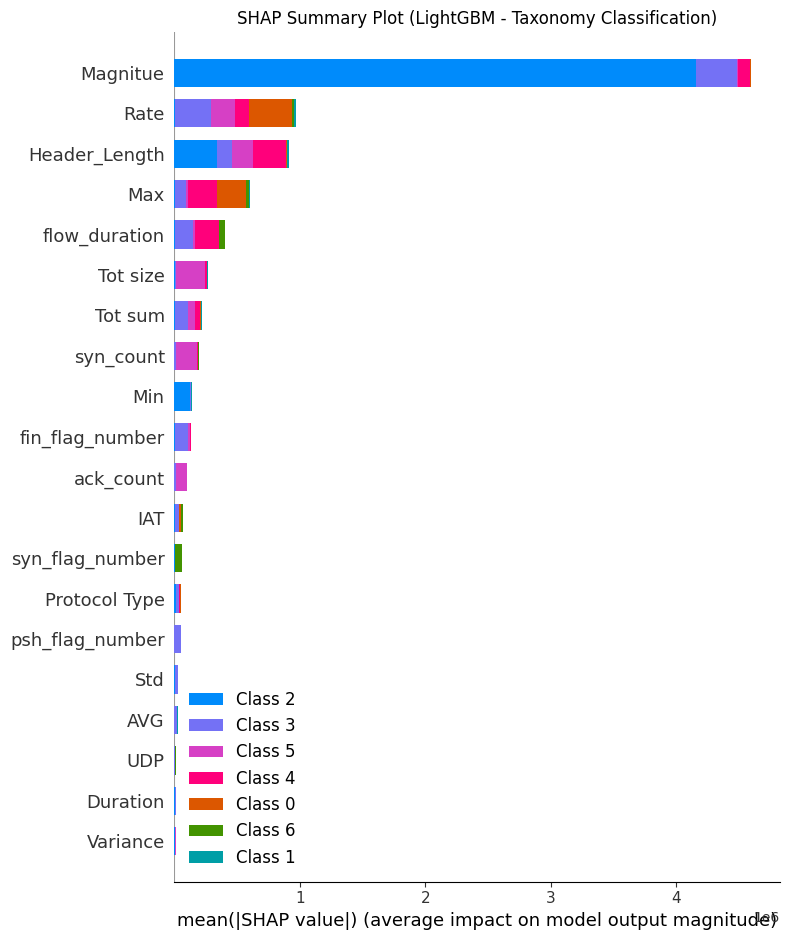

In [31]:
# Sample for SHAP to manage memory
X_sample_lgb = X_test[:1000]

# SHAP Explainer for LightGBM
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb = explainer_lgb.shap_values(X_sample_lgb)

# Feature names from the original data
feature_names = df_clean.drop(columns=['label', 'taxonomy_label']).columns

# SHAP summary plot
plt.title("SHAP Summary Plot (LightGBM - Taxonomy Classification)")
shap.summary_plot(shap_values_lgb, X_sample_lgb, feature_names=feature_names)

The SHAP analysis for the LightGBM classifier indicates a highly concentrated dependence on a single feature-Magnitude. This feature dominates the model's decision-making process for nearly every taxonomy class, especially for Class 2 (flood-based attack), as conveyed mainly by the presence of a dark blue component. Magnitude could probably mean the total volumetric or scales of activity with respect to flow; thus, a very high indication of volumetric attacks like DDoS, and so LightGBM seems to be very biased toward this dimension in its splits.

The second-most impactful feature is Rate, followed, in turn, by Header_Length and Max. These features also weigh into the LightGBM's interpretation of traffic behavior against various attacks, like packet-rate anomalies and header inflation used for evading detection. However, their importance pales in comparison, being many orders of magnitude less than Magnitude, which informs us that the model may heavily rely on a single feature.

Much lower-ranked features such as IAT, Protocol_Type, syn_count, and TCP flags (such as psh_flag_number and ack_count) have very little SHAP impact in this offending model. This means, compared to XGBoost and MLP, LightGBM is underutilizing specific protocol behavior or temporal dynamics. While this might speed up prediction and perform exceptionally well on dominant classes, it may lead to poor generalization of edge-case classes like Injection or Backdoors.

# ***Step 22: StratifiedKFOld for cross-validation of XGBoost Model***

In [32]:
from sklearn.model_selection import StratifiedKFold
# Set up data
df_clean = df.dropna(subset=['taxonomy_label']).copy()
le_cv = LabelEncoder()
y_cv = le_cv.fit_transform(df_clean['taxonomy_label'])
X_cv = X_scaled[df_clean.index]

# Set up 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store metrics
all_reports = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_cv, y_cv)):
    print(f"\n📘 Fold {fold+1}")
    
    X_train, X_test = X_cv[train_idx], X_cv[test_idx]
    y_train, y_test = y_cv[train_idx], y_cv[test_idx]

    # Train XGBoost
    xgb_fold = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(le_cv.classes_),
        scale_pos_weight=None,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=42
    )
    xgb_fold.fit(X_train, y_train)
    
    # Predict and store report
    y_pred = xgb_fold.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=le_cv.classes_, output_dict=True)
    all_reports.append(report)
    print(classification_report(y_test, y_pred, target_names=le_cv.classes_, digits=4))



📘 Fold 1
                      precision    recall  f1-score   support

Backdoors & Exploits     0.7931    0.2035    0.3239       113
              Benign     0.9082    0.9579    0.9324      4895
Botnet/Mirai Attacks     0.9999    0.9999    0.9999     11847
       Flood Attacks     1.0000    1.0000    1.0000    184286
   Injection Attacks     0.6250    0.0847    0.1493        59
      Reconnaissance     0.8109    0.7717    0.7908      1428
     Spoofing / MITM     0.8714    0.8466    0.8588      2210

            accuracy                         0.9950    204838
           macro avg     0.8584    0.6949    0.7222    204838
        weighted avg     0.9949    0.9950    0.9948    204838


📘 Fold 2
                      precision    recall  f1-score   support

Backdoors & Exploits     0.5714    0.1416    0.2270       113
              Benign     0.9148    0.9667    0.9400      4896
Botnet/Mirai Attacks     1.0000    0.9999    1.0000     11846
       Flood Attacks     1.0000    1.0000    1

***Interpretation of Cross-Validation***

Given the 5-fold cross-validation outcomes, the XGBoost classifier performs exceptionally well in classifying IoT network traffic based on the proposed taxonomy. The model achieves consistently high accuracy of 99.5% in all five folds and weighted F1-scores of around 0.995, thereby showing that it cannot go wrong with Flood attacks, Botnet/Mirai, and Benign traffic classes, indicating a high precision and recall on the dominant classes such as Flood Attacks, Botnet/Mirai, and Benign traffic. These results testify to the robustness of the proposed model and its generalization across a large spectrum of attack patterns that are well-represented.


But the netting F1 is an average of 0.71 whereas this suggests that performance across classes, especially the rare and minority, tends to become imbalanced. In fact, the model has a lot of difficulties with this listed underrepresented class of threats, namely Backdoors and Exploits and Injection Attacks, which are showing very low recall rate in a range from 5% to 20%. The classes are identified, as mentioned above, with some precision, but the lack of complete recall reflects the difficulty in detecting this stealthy or zero-day-like behaviors under highly imbalanced training data. Classes, however, such as Spoofing/MITM and Reconnaissance show moderate and stable performance on samples due to their reasonable number of cases and their well-defined behavior.


XGBoost as a whole is the major candidate for the purpose of identifying characteristics of major, well-described threats in IoT networks and, possibly, the strong default for taxonomy-based classification. The limitation of the model with rare classes calls for future improvements by either employing oversampling techniques or through hybrid modeling with anomaly-aware characteristics.

# ***MLP (PyTorch) Cross-Validation***

In [33]:
# Data prep
df_clean = df.dropna(subset=['taxonomy_label']).copy()
le_mlp = LabelEncoder()
y_cv = le_mlp.fit_transform(df_clean['taxonomy_label'])
X_cv = X_scaled[df_clean.index]

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_cv, dtype=torch.float32)
y_tensor = torch.tensor(y_cv, dtype=torch.long)

# Define MLP again
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Start CV
for fold, (train_idx, test_idx) in enumerate(skf.split(X_cv, y_cv)):
    print(f"\n📘 Fold {fold+1}")
    
    X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
    y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=512, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=512)

    # Model setup
    model = MLP(X_cv.shape[1], len(le_mlp.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop (50 epochs)
    for epoch in range(50):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

    # Evaluation
    model.eval()
    all_preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            out = model(xb)
            preds = torch.argmax(out, dim=1)
            all_preds.extend(preds.cpu().numpy())

    # Print classification report
    print(classification_report(y_test.numpy(), all_preds, target_names=le_mlp.classes_, digits=4))



📘 Fold 1
Epoch 1 - Loss: 111.0840
Epoch 2 - Loss: 50.5691
Epoch 3 - Loss: 45.8600
Epoch 4 - Loss: 44.1395
Epoch 5 - Loss: 43.0214
Epoch 6 - Loss: 42.0237
Epoch 7 - Loss: 41.4362
Epoch 8 - Loss: 41.2856
Epoch 9 - Loss: 40.7793
Epoch 10 - Loss: 40.3231
Epoch 11 - Loss: 40.1448
Epoch 12 - Loss: 40.0251
Epoch 13 - Loss: 39.8538
Epoch 14 - Loss: 39.4390
Epoch 15 - Loss: 39.4168
Epoch 16 - Loss: 39.3309
Epoch 17 - Loss: 39.4493
Epoch 18 - Loss: 38.9709
Epoch 19 - Loss: 38.9974
Epoch 20 - Loss: 38.6419
Epoch 21 - Loss: 38.6551
Epoch 22 - Loss: 38.4968
Epoch 23 - Loss: 38.4202
Epoch 24 - Loss: 38.2663
Epoch 25 - Loss: 38.1861
Epoch 26 - Loss: 38.3880
Epoch 27 - Loss: 38.4562
Epoch 28 - Loss: 38.1524
Epoch 29 - Loss: 38.0214
Epoch 30 - Loss: 37.9277
Epoch 31 - Loss: 37.8230
Epoch 32 - Loss: 37.6611
Epoch 33 - Loss: 37.9121
Epoch 34 - Loss: 38.1616
Epoch 35 - Loss: 37.5728
Epoch 36 - Loss: 37.7804
Epoch 37 - Loss: 37.7819
Epoch 38 - Loss: 37.3629
Epoch 39 - Loss: 37.4382
Epoch 40 - Loss: 37.405

# ***MLP (PyTorch) Cross-Validation Summary – Interpretation***

This model gives a more or less similar result for each fold of five-fold train-test cross-validation. On a random note, the model achieves an overall accuracy of about 99.1–99.2% and weighted F1 scores near 0.99, which indicates that it is dealing very well in precisions and recalls for the most class instances, such as Flood Attack, Botnet/Mirai, and Benign traffic. For example, an F1-score of nearly perfect-up to≈0.9998- for Flood Attacks, while Botnet traffic consistently gives precision and recall of more than 99%.

Yet, the model is not good enough to apply to minority and stealthy classes, which is reflected in the much lower macro-averaged F1-scores (about ~0.65–0.66). Within this range, Injection Attacks and Backdoors & Exploits show very low recall (1.6% to 13%) but may sometimes be highly precise, which indicates that the model can identify these classes when very confident but not generally applicable due to their rarity in the dataset. Spoofing / MITM and Reconnaissance perform moderately well, with F1 scores around 0.72 to 0.75, and slightly unstable recall across folds.

The model MLP is rich and highly effective in high-volume attack detection and has promises for learning deep feature interactions such as through TCP flags because it showed a really good initial promising performance as presented in SHAP but requires a lot of tuning or augmentation such oversampling or class weighting to adjust to rare or subtle attack types.

#  ***5-Fold Cross-Validation for RandomForest***


In [34]:

# Prepare data
df_clean = df.dropna(subset=['taxonomy_label']).copy()
le_rf_cv = LabelEncoder()
y_rf_cv = le_rf_cv.fit_transform(df_clean['taxonomy_label'])
X_rf_cv = X_scaled[df_clean.index]

# Setup StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through folds
for fold, (train_idx, test_idx) in enumerate(skf.split(X_rf_cv, y_rf_cv)):
    print(f"\n📘 Fold {fold+1}")
    
    X_train, X_test = X_rf_cv[train_idx], X_rf_cv[test_idx]
    y_train, y_test = y_rf_cv[train_idx], y_rf_cv[test_idx]

    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = rf_model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le_rf_cv.classes_))



📘 Fold 1
                      precision    recall  f1-score   support

Backdoors & Exploits       1.00      0.21      0.35       113
              Benign       0.89      0.97      0.93      4895
Botnet/Mirai Attacks       1.00      1.00      1.00     11847
       Flood Attacks       1.00      1.00      1.00    184286
   Injection Attacks       0.74      0.29      0.41        59
      Reconnaissance       0.85      0.76      0.80      1428
     Spoofing / MITM       0.90      0.83      0.86      2210

            accuracy                           0.99    204838
           macro avg       0.91      0.72      0.77    204838
        weighted avg       0.99      0.99      0.99    204838


📘 Fold 2
                      precision    recall  f1-score   support

Backdoors & Exploits       0.90      0.17      0.28       113
              Benign       0.89      0.97      0.93      4896
Botnet/Mirai Attacks       1.00      0.99      1.00     11846
       Flood Attacks       1.00      1.00     

The RandomForest model demonstrated very strong and stable performance across all five folds, achieving about ~99% accuracy and weighted F1-scores close to 0.99. It performed outstandingly with the overwhelming classes, including Flood Attacks, Botnet/Mirai, and Benign traffic. RandomForest surpassed the rest of the models in detecting injection attacks and backdoors, which are rare classes, though recall was still low (17% to 30%). It also performed with the same consistency on Spoofing and Reconnaissance traffic, recording F1-scores of around 0.80-0.86. Overall, this model performs well-balanced and dependable for common as well as rare IoT attack types.

# ***5-Fold Cross-Validation for LightGBM***

In [35]:
# Prepare data
df_clean = df.dropna(subset=['taxonomy_label']).copy()
le_lgb_cv = LabelEncoder()
y_lgb_cv = le_lgb_cv.fit_transform(df_clean['taxonomy_label'])
X_lgb_cv = X_scaled[df_clean.index]

# Set up StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through folds
for fold, (train_idx, test_idx) in enumerate(skf.split(X_lgb_cv, y_lgb_cv)):
    print(f"\n📘 Fold {fold+1}")

    X_train, X_test = X_lgb_cv[train_idx], X_lgb_cv[test_idx]
    y_train, y_test = y_lgb_cv[train_idx], y_lgb_cv[test_idx]

    # LightGBM model
    lgb_model = lgb.LGBMClassifier(
        objective='multiclass',
        num_class=len(le_lgb_cv.classes_),
        is_unbalance=True,
        n_estimators=100,
        random_state=42
    )
    lgb_model.fit(X_train, y_train)

    # Predict and report
    y_pred = lgb_model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le_lgb_cv.classes_))



📘 Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5327
[LightGBM] [Info] Number of data points in the train set: 819350, number of used features: 40
[LightGBM] [Info] Start training from score -7.507019
[LightGBM] [Info] Start training from score -3.733952
[LightGBM] [Info] Start training from score -2.850185
[LightGBM] [Info] Start training from score -0.105731
[LightGBM] [Info] Start training from score -8.135628
[LightGBM] [Info] Start training from score -4.966643
[LightGBM] [Info] Start training from score -4.528885
                      precision    recall  f1-score   support

Backdoors & Exploits       0.08      0.16      0.10       113
              Benign       0.87      0.92      0.89      4895
Botnet/Mirai Attacks       0.99      1.00      0.99     11847
       Fl

LightGBM exhibited outstanding performance with respect to its predominant classes such as Flood Attacks and Botnet by scoring more than 99 % in accuracy along with weighted F1 scores close to 0.99 across all folds. However, it performed poorly in the classes Backdoors and Injection Attacks, showing a low recall score (very often below 20 %) despite having high precision values in some cases. Mid-range classes, such as Spoofing and Reconnaissance, showed somewhat moderate and stable F1 scores (~0.65-0.77). Overall, LightGBM handles common attacks very quickly and efficiently but weak with subtle threats.
